# Sequence Analysis: Arsenal, 2003-04

This workflow uses data sourced from [Statsbomb open data](https://statsbomb.com/what-we-do/hub/free-data/). It aims to identify common events and sequences of events which immediately precede shots (incl goals) and visualise these for the purpose of informing tactics.

[API usage instructions](https://github.com/statsbomb/statsbombpy/tree/master/statsbombpy)<br>

[PrexfixSpan-py](https://github.com/chuanconggao/PrefixSpan-py)<br>

Up the Gunners

In [3]:
#!pip install prefixspan
#!pip install mplsoccer

In [1]:
# import libraries

from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from prefixspan import PrefixSpan
import pandas as pd
from scipy.stats import rankdata

In [229]:
# read single match data

match = pd.read_csv('data/2_44_1_all_data.csv')

In [232]:
# view columns and explore data

#match.head(1)
#list(match)
col_of_interest='shot_outcome'
match[col_of_interest].value_counts()

shot_outcome
Off T               341
Saved               235
Blocked             198
Goal                 94
Wayward              34
Post                 19
Saved Off Target      6
Saved to Post         2
Name: count, dtype: int64

In [233]:
# select required columns

req_cols=['match_id','index','type','team','player','player_id',
          'position','shot_statsbomb_xg', 'shot_outcome','location', 
          'pass_end_location','carry_end_location', 'pass_recipient']

match_1_events=match[req_cols]

In [234]:
import warnings
warnings.filterwarnings('ignore')

# clean and process
#match_1_events['type.id'] = match_1_events['type.id'].astype(str).str.zfill(2)
match_1_events['player_id'] = match_1_events['player_id'].fillna('00000')
match_1_events['player_id'] = match_1_events['player_id'].astype(str).str.split('.', expand=True)[0]

# split locations to X and Y columns
match_1_events[['location_x', 'location_y']] = match_1_events['location'].str.extract(r'\[(.*), (.*)\]').astype(float)
match_1_events[['pass.end_location_x', 'pass.end_location_y']] = match_1_events['pass_end_location'].str.extract(r'\[(.*), (.*)\]').astype(float)
match_1_events[['carry.end_location_x', 'carry.end_location_y']] = match_1_events['carry_end_location'].str.extract(r'\[(.*), (.*)\]').astype(float)

match_1_events = match_1_events.drop(['location', 'pass_end_location', 'carry_end_location'], axis=1)



In [235]:
#remove unwanted events
#match_1_events = match_1_events[match_1_events['type'] != 'Carry']
#match_1_events = match_1_events[match_1_events['type'] != 'Ball Receipt*']


In [237]:
# add column combining type and player
match_1_events["type_player"] = match_1_events["type"].astype(str) + match_1_events["player_id"].astype(str)
#match_1_events["type_player"] = match_1_events["player"].astype(str) + match_1_events["type"].astype(str) + match_1_events["pass_recipient"].astype(str)
match_1_events=match_1_events.sort_values(by=['match_id', 'index'])
match_1_events.head(5)

,match_id,index,type,team,player,player_id,position,shot_statsbomb_xg,shot_outcome,pass_recipient,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_player
0,3749052,1,Starting XI,Wolverhampton Wanderers,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Starting XI00000
1,3749052,2,Starting XI,Arsenal,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Starting XI00000
76,3749052,3,Half Start,Arsenal,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Half Start00000
77,3749052,4,Half Start,Wolverhampton Wanderers,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Half Start00000
228,3749052,5,Pass,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,Dennis Bergkamp,61.0,40.1,61.4,43.6,NaN,NaN,Pass15516


In [238]:
# select only Arsenal events
match_1_ars=match_1_events[match_1_events['team']=='Arsenal'].reset_index(drop=True)
all_ars_players=match_1_ars[['player','player_id']].drop_duplicates().dropna()

In [240]:
# arsenal only events
match_1_shots=match_1_ars[match_1_ars['type']=='Shot']
match_1_shots['shot_outcome'].value_counts()

shot_outcome
Off T               189
Saved               147
Blocked             101
Goal                 69
Wayward              17
Post                 14
Saved Off Target      5
Saved to Post         2
Name: count, dtype: int64

In [246]:
# for each 'shot' type.name, create a list of the preceding n events. Append each list to a master list.
# also create a list of event indexes.

shot_events = []
event_indexes = []
play_outcome = []
play_xG = []
for i, row in match_1_ars.iterrows():
    if row['type'] == 'Shot':
        outcome = row['shot_outcome']
        xG = row['shot_statsbomb_xg']
        start_index = max(0, i - 10)  # Calculate the start index, ensuring it doesn't go below 0
        indexes = list(range(start_index, i))
        event_indexes.extend(indexes)
        single_shot_events=[]
        for j in indexes:
            event=match_1_ars['type_player'][j]
            single_shot_events.append(event)
            play_outcome.append(outcome)
            play_xG.append(xG)
        shot_events.append(single_shot_events)
        
len(shot_events)

544

In [247]:
# get event data with event indexes

leading_events=match_1_ars.loc[event_indexes]
leading_events['play_outcome'] = play_outcome
leading_events['play_xG'] = play_xG
leading_events['play_xG_ranked'] = rankdata(play_xG) / (len(play_xG) + 1)
leading_events.head(3)

,match_id,index,type,team,player,player_id,position,shot_statsbomb_xg,shot_outcome,pass_recipient,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_player,play_outcome,play_xG,play_xG_ranked
201,3749052,350,Ball Recovery,Arsenal,Patrick Vieira,15515,Right Defensive Midfield,NaN,NaN,NaN,52.6,57.5,NaN,NaN,NaN,NaN,Ball Recovery15515,Goal,0.193885,0.844606
202,3749052,351,Carry,Arsenal,Patrick Vieira,15515,Right Defensive Midfield,NaN,NaN,NaN,52.6,57.5,NaN,NaN,52.6,54.3,Carry15515,Goal,0.193885,0.844606
203,3749052,352,Pass,Arsenal,Patrick Vieira,15515,Right Defensive Midfield,NaN,NaN,Eduardo César Daude Gaspar,52.6,54.3,54.6,45.0,NaN,NaN,Pass15515,Goal,0.193885,0.844606


In [248]:
# use ps algorithm on shot events list of lists.
ps = PrefixSpan(shot_events)

results = ps.frequent(100)

In [249]:
# sort results by support count (desc)
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)
sorted_results

[(291, ['Ball Receipt*15516']),
 (272, ['Carry15516']),
 (235, ['Ball Receipt*15516', 'Carry15516']),
 (206, ['Pass19312']),
 (188, ['Pass15516']),
 (173, ['Ball Receipt*19312']),
 (169, ['Carry19312']),
 (147, ['Carry15516', 'Pass15516']),
 (139, ['Carry19312', 'Pass19312']),
 (135, ['Ball Receipt*15516', 'Pass15516']),
 (135, ['Ball Receipt*19312', 'Carry19312']),
 (133, ['Pass15515']),
 (124, ['Ball Receipt*19312', 'Pass19312']),
 (123, ['Carry15515']),
 (120, ['Ball Receipt*15042']),
 (120, ['Ball Receipt*15515']),
 (119, ['Ball Receipt*15516', 'Carry15516', 'Pass15516']),
 (111, ['Carry15042']),
 (111, ['Ball Receipt*15754']),
 (107, ['Ball Receipt*19312', 'Carry19312', 'Pass19312']),
 (103, ['Carry15515', 'Pass15515']),
 (102, ['Pass15042'])]

In [250]:
# select most common event
common_event=sorted_results[0][1][0]
common_event

'Ball Receipt*15516'

In [251]:
# find data on all occurences of most common event
common_event_data=leading_events[leading_events['type_player']==common_event].reset_index(drop=True)
common_event_data.head()

,match_id,index,type,team,player,player_id,position,shot_statsbomb_xg,shot_outcome,pass_recipient,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_player,play_outcome,play_xG,play_xG_ranked
0,3749052,472,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,103.3,9.4,NaN,NaN,NaN,NaN,Ball Receipt*15516,Saved,0.007914,0.045120
1,3749052,472,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,103.3,9.4,NaN,NaN,NaN,NaN,Ball Receipt*15516,Off T,0.125604,0.758225
2,3749052,1478,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,89.8,25.9,NaN,NaN,NaN,NaN,Ball Receipt*15516,Saved,0.147070,0.798658
3,3749052,1486,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,94.8,27.1,NaN,NaN,NaN,NaN,Ball Receipt*15516,Saved,0.147070,0.798658
4,3749052,1869,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,95.5,2.7,NaN,NaN,NaN,NaN,Ball Receipt*15516,Off T,0.036048,0.385131


In [252]:
n_shots=len(match_1_shots)
n_common_events=len(common_event_data)
player_name=common_event_data.loc[0]['player']
type_name=common_event_data.loc[0]['type']
pc_common_event=round((n_common_events/n_shots)*100,2)

print(f"In the 2003-04 season, Arsenal had {n_shots} shots. {pc_common_event}% of these were preceeded by a {type_name} by {player_name}.")

In the 2003-04 season, Arsenal had 544 shots. 59.19% of these were preceeded by a Ball Receipt* by Thierry Henry.


In [253]:
len(common_event_data['play_xG_ranked'])

322

In [254]:
import numpy as np
common_event_data['col']=np.where(common_event_data['play_outcome']=="Goal", "red", "black")


In [255]:
common_event[:-5]

'Ball Receipt*'

In [257]:
# box plots of xG and shot outcome

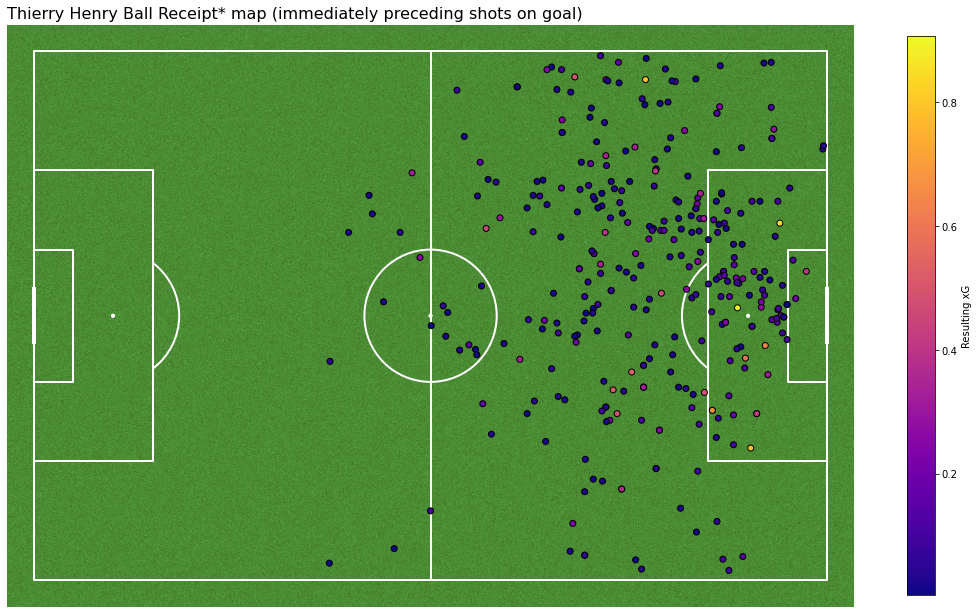

In [271]:
# visualise events
cmap = plt.cm.get_cmap('plasma')
color_by='play_xG'
colors = cmap(common_event_data[color_by])

event_id= common_event[:-5]
pitch = Pitch(pitch_color='grass', line_color='white', stripe=False)
fig, ax = pitch.draw(figsize=(15, 10))

if event_id=='Ball Receipt*':
    ax.scatter(common_event_data['location_x'], common_event_data['location_y'], c=common_event_data[color_by],
               cmap="plasma", edgecolor='black', zorder=10)
elif event_id=='Pass':
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['pass.end_location_x'] - common_event_data['location_x'], common_event_data['pass.end_location_y'] - common_event_data['location_y'], 
             color=colors, scale_units='xy', angles='xy', scale=1, width=0.002)
elif event_id=='Carry': 
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['carry.end_location_x'] - common_event_data['location_x'], common_event_data['carry.end_location_y'] - common_event_data['location_y'], 
             color=colors, scale_units='xy', angles='xy', scale=1, width=0.002)
else:
    print("Event must be a ball receipt, carry or pass")
ax.set_title(f"{player_name} {type_name} map (immediately preceding shots on goal)", fontsize=16, loc='left')
# Add colorbar legend
sm = ScalarMappable(cmap=cmap)
sm.set_array(common_event_data[color_by])
plt.colorbar(sm, ax=ax, shrink=0.8, label="Resulting xG")
plt.show()


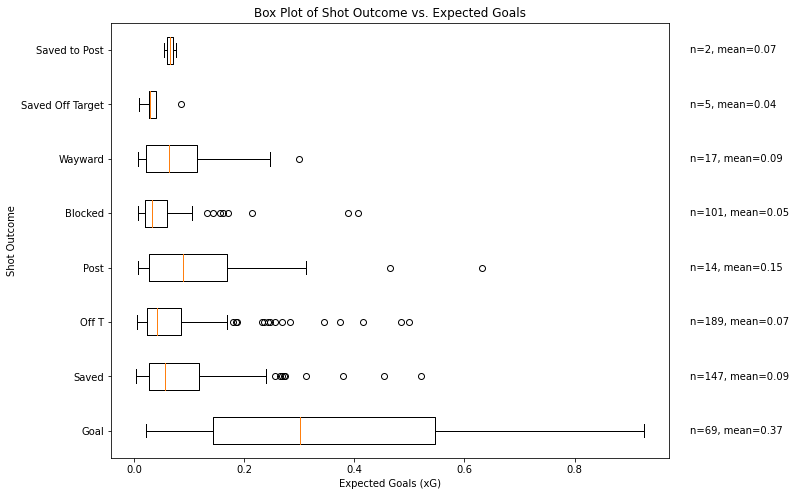

In [416]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'match_1_shots'
shot_outcome = match_1_shots['shot_outcome']
shot_statsbomb_xg = match_1_shots['shot_statsbomb_xg']

# Group the shot_statsbomb_xg data based on shot_outcome
data = [shot_statsbomb_xg[shot_outcome == outcome] for outcome in shot_outcome.unique()]

# Create a horizontal box plot with a larger figure size
plt.figure(figsize=(10, 8))
box_plot = plt.boxplot(data, labels=shot_outcome.unique(), vert=False)

# Set labels and title
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Shot Outcome')
plt.title('Box Plot of Shot Outcome vs. Expected Goals')

# Add counts and mean xG to the plot
for i, outcome in enumerate(shot_outcome.unique()):
    count = len(data[i])
    mean_xg = np.mean(data[i])
    plt.text(1.01, i + 1, f'n={count}, mean={mean_xg:.2f}', va='center', ha='left')

# Display the plot
plt.show()


In [ ]:
# caveats

# good opportunities != shots and xG. Martinelli vs Liverpool
# For example, a counter attacking 3v1 situation may appear a good goal scoring opportunity. However, 
# should the attacker in possession fail to execute their pass to a teammate, a shot (and cosequently, xG) 
# may not be recorded